<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.5 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 244MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:42<00:00,  2.42it/s]


epoch: 0, lossD:1.2836719381722432, lossG:20.989606848040832,lossG_fake:15.529750293898351, lossG_real:5.459856493959149 ,equality:10.069893799939202


evaluate:218.75518798828125,kid_mean:0.18426117300987244, kid_std:0.026013853028416634,kid_:(tensor(0.1843), tensor(0.0260))


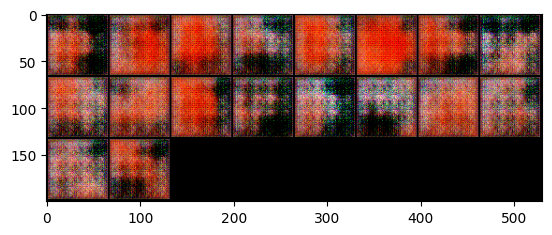

100%|██████████| 103/103 [00:09<00:00, 11.01it/s]


epoch: 1, lossD:0.8276158474494242, lossG:8.944517445795745,lossG_fake:5.005375173485395, lossG_real:3.9391422537200658 ,equality:1.066232919765329


evaluate:150.69332885742188,kid_mean:0.10816679894924164, kid_std:0.03919408470392227,kid_:(tensor(0.1082), tensor(0.0392))


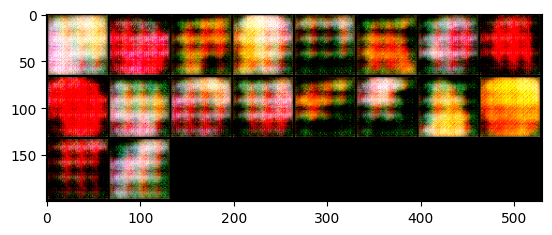

100%|██████████| 103/103 [00:09<00:00, 10.94it/s]


epoch: 2, lossD:1.235972289321492, lossG:7.53037408254679,lossG_fake:4.460852327150772, lossG_real:3.0695217970071487 ,equality:1.3913305301436236


evaluate:138.12789916992188,kid_mean:0.08924368023872375, kid_std:0.03455245867371559,kid_:(tensor(0.0892), tensor(0.0346))


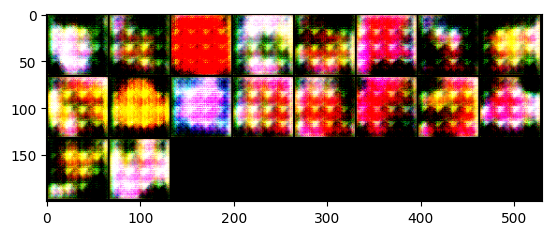

100%|██████████| 103/103 [00:09<00:00, 10.86it/s]


epoch: 3, lossD:1.0685339737864374, lossG:8.072415458345876,lossG_fake:4.9503348197751835, lossG_real:3.122080661428785 ,equality:1.8282541583463985


evaluate:145.34852600097656,kid_mean:0.10171787440776825, kid_std:0.04004839062690735,kid_:(tensor(0.1017), tensor(0.0400))


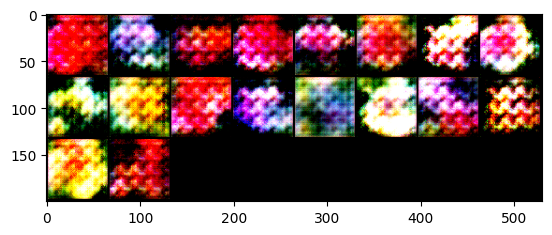

100%|██████████| 103/103 [00:09<00:00, 10.80it/s]


epoch: 4, lossD:1.0042038601868362, lossG:7.22428639884134,lossG_fake:4.25216511152323, lossG_real:2.972121286160738 ,equality:1.2800438253624926


evaluate:141.68138122558594,kid_mean:0.10595479607582092, kid_std:0.04974369704723358,kid_:(tensor(0.1060), tensor(0.0497))


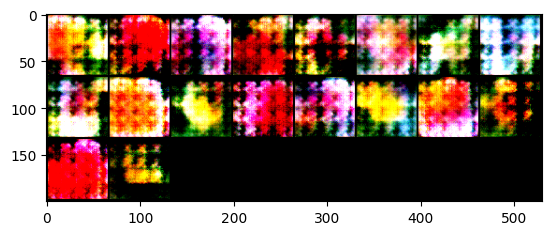

100%|██████████| 103/103 [00:09<00:00, 10.73it/s]


epoch: 5, lossD:0.9053189336385542, lossG:7.121114883608031,lossG_fake:4.216249881438839, lossG_real:2.9048649945016045 ,equality:1.3113848869372342


evaluate:134.28305053710938,kid_mean:0.08950239419937134, kid_std:0.04230981320142746,kid_:(tensor(0.0895), tensor(0.0423))


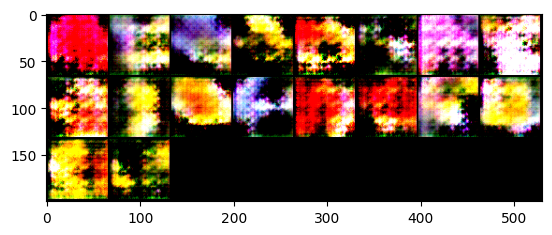

100%|██████████| 103/103 [00:09<00:00, 10.64it/s]


epoch: 6, lossD:0.9204422124091861, lossG:6.854150577656274,lossG_fake:3.96931301968769, lossG_real:2.884837550445668 ,equality:1.084475469242022


evaluate:133.25526428222656,kid_mean:0.09190797805786133, kid_std:0.03964883089065552,kid_:(tensor(0.0919), tensor(0.0396))


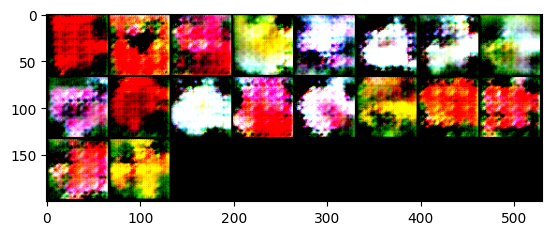

100%|██████████| 103/103 [00:09<00:00, 10.64it/s]


epoch: 7, lossD:0.8247233683116806, lossG:7.371495496879503,lossG_fake:4.252258028798891, lossG_real:3.1192374342998255 ,equality:1.1330205944990652


evaluate:130.76998901367188,kid_mean:0.08289072662591934, kid_std:0.039379313588142395,kid_:(tensor(0.0829), tensor(0.0394))


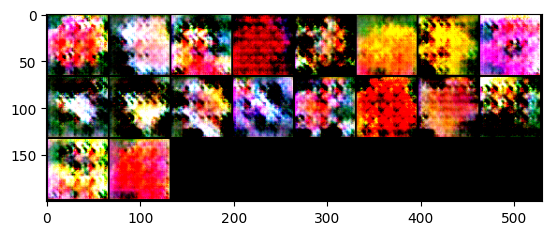

100%|██████████| 103/103 [00:09<00:00, 10.51it/s]


epoch: 8, lossD:0.9304691030128488, lossG:7.190595839787456,lossG_fake:4.044822988000888, lossG_real:3.145772864517656 ,equality:0.899050123483232


evaluate:134.0948486328125,kid_mean:0.08020279556512833, kid_std:0.0392899364233017,kid_:(tensor(0.0802), tensor(0.0393))


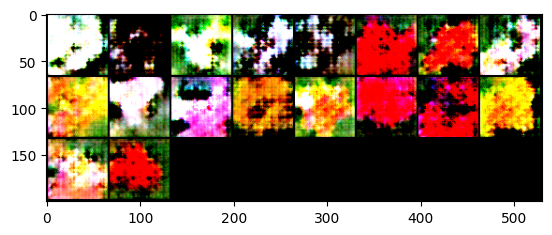

100%|██████████| 103/103 [00:09<00:00, 10.42it/s]


epoch: 9, lossD:0.8881218387085257, lossG:7.07737791191027,lossG_fake:4.095313767785007, lossG_real:2.9820641441252627 ,equality:1.1132496236597444


evaluate:134.42474365234375,kid_mean:0.08071354031562805, kid_std:0.04649655893445015,kid_:(tensor(0.0807), tensor(0.0465))


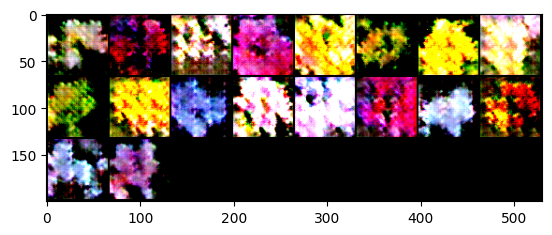

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 10, lossD:0.8752515499742286, lossG:7.044583144697171,lossG_fake:4.116371034997181, lossG_real:2.9282121340047964 ,equality:1.1881589009923847


evaluate:137.26756286621094,kid_mean:0.09760741889476776, kid_std:0.04505202919244766,kid_:(tensor(0.0976), tensor(0.0451))


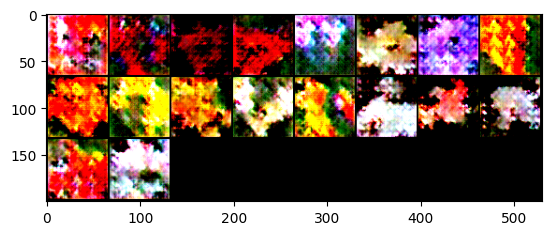

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 11, lossD:0.9367346070634509, lossG:7.149731747155051,lossG_fake:4.035232828080075, lossG_real:3.114498949745326 ,equality:0.9207338783347492


evaluate:136.8003387451172,kid_mean:0.09212585538625717, kid_std:0.0492708645761013,kid_:(tensor(0.0921), tensor(0.0493))


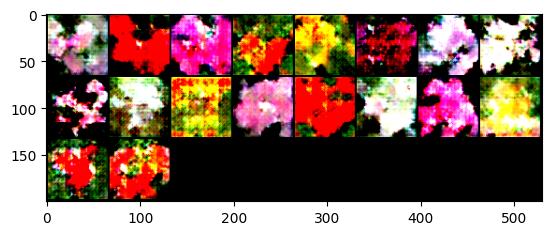

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 12, lossD:0.9890489416215026, lossG:6.9318106197616425,lossG_fake:3.8737117468732074, lossG_real:3.0580988992186424 ,equality:0.815612847654565


evaluate:133.5814666748047,kid_mean:0.09159363061189651, kid_std:0.04716547206044197,kid_:(tensor(0.0916), tensor(0.0472))


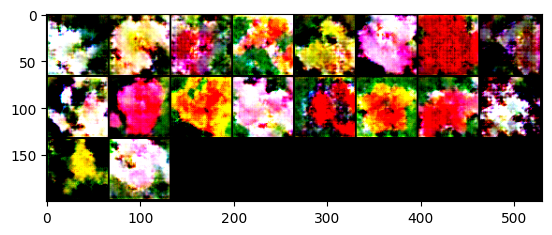

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 13, lossD:1.1064271382915163, lossG:6.527330120790352,lossG_fake:3.634016574586479, lossG_real:2.8933135612497054 ,equality:0.7407030133367738


evaluate:124.50284576416016,kid_mean:0.0843127891421318, kid_std:0.04447932541370392,kid_:(tensor(0.0843), tensor(0.0445))


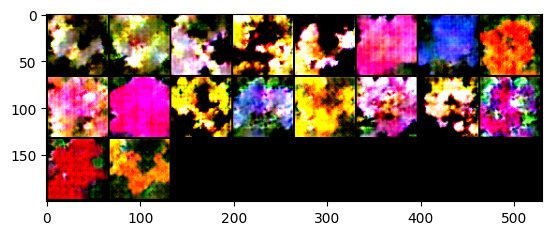

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 14, lossD:0.9176182120459752, lossG:6.789927876111373,lossG_fake:3.7629006672831413, lossG_real:3.0270272047774305 ,equality:0.7358734625057108


evaluate:126.2168960571289,kid_mean:0.0855870246887207, kid_std:0.04895593971014023,kid_:(tensor(0.0856), tensor(0.0490))


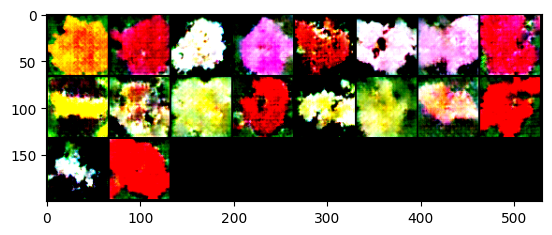

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 15, lossD:0.88970731820875, lossG:6.8099188804626465,lossG_fake:3.775161169107678, lossG_real:3.03475770556811 ,equality:0.7404034635395678


evaluate:118.94651794433594,kid_mean:0.10000432282686234, kid_std:0.04886170104146004,kid_:(tensor(0.1000), tensor(0.0489))


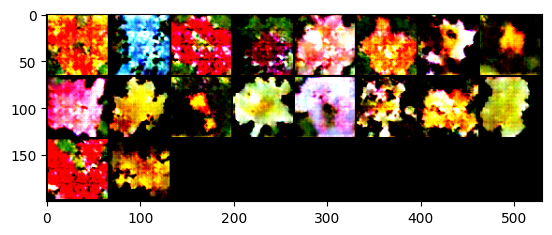

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 16, lossD:0.8017645860181272, lossG:7.036123155390174,lossG_fake:3.900610300522406, lossG_real:3.135512845030109 ,equality:0.7650974554922971


evaluate:116.96265411376953,kid_mean:0.08684992790222168, kid_std:0.04440498352050781,kid_:(tensor(0.0868), tensor(0.0444))


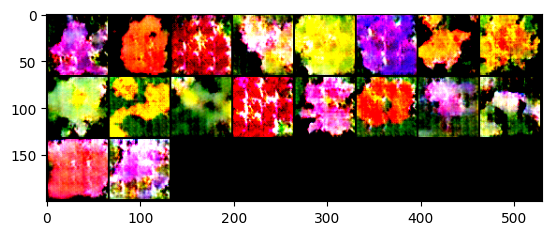

100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


epoch: 17, lossD:0.6999354566474563, lossG:7.188575022428939,lossG_fake:3.911559621685917, lossG_real:3.2770153932201054 ,equality:0.6345442284658116


evaluate:116.37860870361328,kid_mean:0.09239479899406433, kid_std:0.049172379076480865,kid_:(tensor(0.0924), tensor(0.0492))


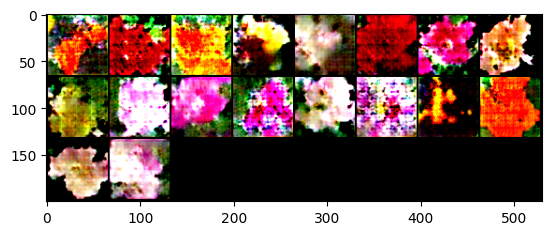

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 18, lossD:0.7311460041594737, lossG:7.392824186862094,lossG_fake:4.019734406644858, lossG_real:3.3730897654607457 ,equality:0.6466446411841122


evaluate:118.09571075439453,kid_mean:0.08480842411518097, kid_std:0.045983996242284775,kid_:(tensor(0.0848), tensor(0.0460))


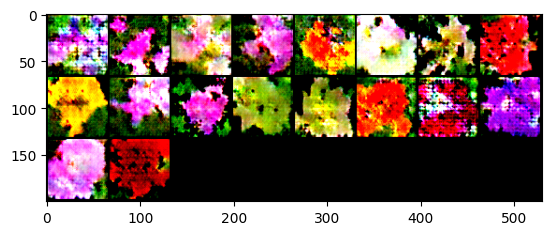

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 19, lossD:0.6873456215106167, lossG:7.780308640118942,lossG_fake:4.396760233397623, lossG_real:3.3835483853099415 ,equality:1.013211848087681


evaluate:118.87945556640625,kid_mean:0.08327958732843399, kid_std:0.04275744780898094,kid_:(tensor(0.0833), tensor(0.0428))


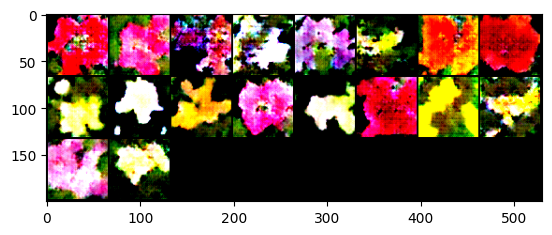

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 20, lossD:0.6087033746999155, lossG:7.508231709304365,lossG_fake:4.048366888055524, lossG_real:3.459864851340507 ,equality:0.5885020367150169


evaluate:120.30398559570312,kid_mean:0.09657219052314758, kid_std:0.05292249098420143,kid_:(tensor(0.0966), tensor(0.0529))


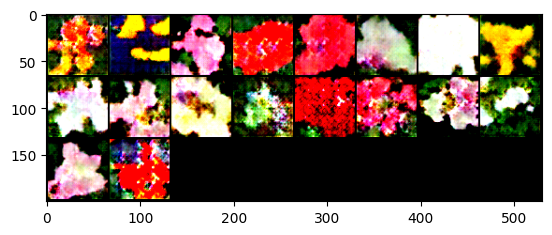

100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


epoch: 21, lossD:0.6131571384635076, lossG:7.624009632369847,lossG_fake:4.059169108427844, lossG_real:3.5648404840126777 ,equality:0.49432862441516656


evaluate:117.36174774169922,kid_mean:0.08319847285747528, kid_std:0.0429195910692215,kid_:(tensor(0.0832), tensor(0.0429))


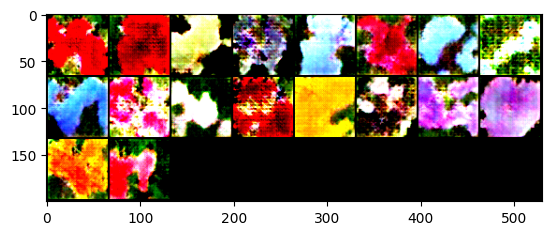

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 22, lossD:0.5243999151675736, lossG:8.306139376556988,lossG_fake:4.509285161796125, lossG_real:3.79685420550189 ,equality:0.7124309562942353


evaluate:117.87442016601562,kid_mean:0.08485256880521774, kid_std:0.047222621738910675,kid_:(tensor(0.0849), tensor(0.0472))


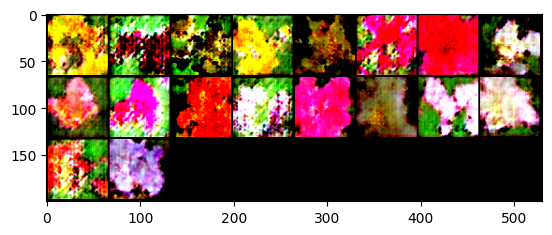

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 23, lossD:0.5128639539323964, lossG:8.314835099340643,lossG_fake:4.4367884802586826, lossG_real:3.87804659246241 ,equality:0.5587418877962724


evaluate:118.64590454101562,kid_mean:0.09548333287239075, kid_std:0.04778936877846718,kid_:(tensor(0.0955), tensor(0.0478))


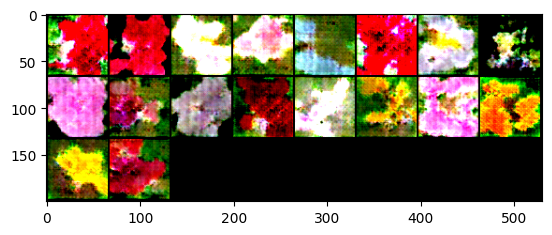

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 24, lossD:0.4988860826469162, lossG:8.033973235528446,lossG_fake:4.375052677774892, lossG_real:3.6589205635404123 ,equality:0.7161321142344801


evaluate:119.59838104248047,kid_mean:0.08679372072219849, kid_std:0.04416853189468384,kid_:(tensor(0.0868), tensor(0.0442))


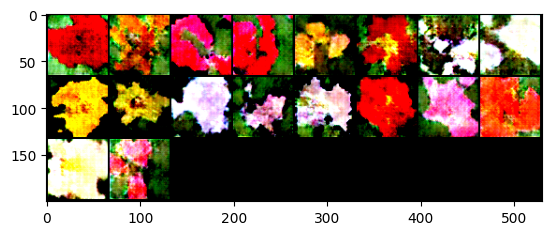

100%|██████████| 103/103 [00:09<00:00, 10.41it/s]


epoch: 25, lossD:0.4150229741285727, lossG:8.238091385480269,lossG_fake:4.385549633827024, lossG_real:3.852541753389303 ,equality:0.533007880437721


evaluate:118.28703308105469,kid_mean:0.08844228088855743, kid_std:0.051241472363471985,kid_:(tensor(0.0884), tensor(0.0512))


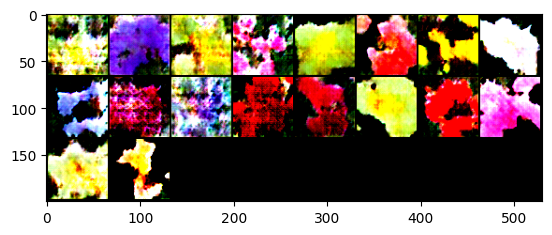

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 26, lossD:0.48798167844782175, lossG:8.435152734367593,lossG_fake:4.453828651928207, lossG_real:3.981324068550925 ,equality:0.4725045833772823


evaluate:115.76517486572266,kid_mean:0.08315004408359528, kid_std:0.04216107353568077,kid_:(tensor(0.0832), tensor(0.0422))


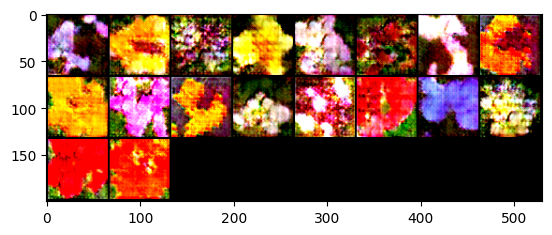

100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


epoch: 27, lossD:0.3858282922143207, lossG:8.647205973134458,lossG_fake:4.630275020900282, lossG_real:4.016930954548919 ,equality:0.6133440663513623


evaluate:116.52630615234375,kid_mean:0.08336540311574936, kid_std:0.0395968034863472,kid_:(tensor(0.0834), tensor(0.0396))


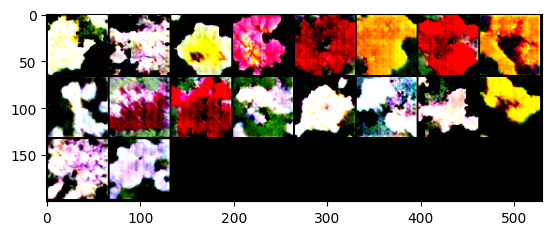

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 28, lossD:0.33834672543826033, lossG:8.964991828770314,lossG_fake:4.797469346847349, lossG_real:4.167522495232739 ,equality:0.6299468516146094


evaluate:118.04270935058594,kid_mean:0.089152030646801, kid_std:0.043332234025001526,kid_:(tensor(0.0892), tensor(0.0433))


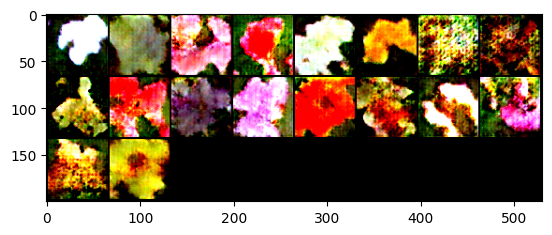

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 29, lossD:0.3693002645577331, lossG:9.221553436760763,lossG_fake:4.986544285005736, lossG_real:4.235009134394451 ,equality:0.7515351506112848


evaluate:117.74382781982422,kid_mean:0.091840460896492, kid_std:0.0449451208114624,kid_:(tensor(0.0918), tensor(0.0449))


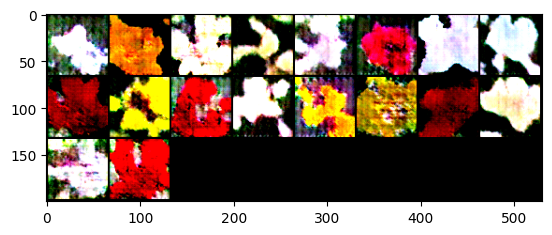

100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


epoch: 30, lossD:0.3967348215830268, lossG:9.146077818083532,lossG_fake:4.907448274417988, lossG_real:4.238629558711376 ,equality:0.6688187157066121


evaluate:117.21485900878906,kid_mean:0.07574209570884705, kid_std:0.04069128260016441,kid_:(tensor(0.0757), tensor(0.0407))


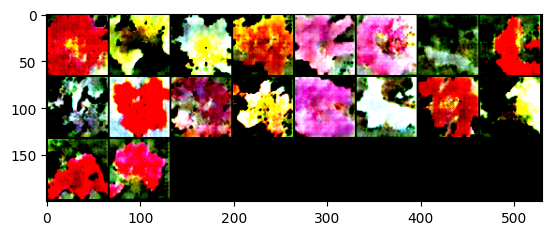

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 31, lossD:0.21613816139333455, lossG:9.338058508715584,lossG_fake:4.925606298215181, lossG_real:4.412452180408737 ,equality:0.5131541178064438


evaluate:116.85540008544922,kid_mean:0.08994922786951065, kid_std:0.04570947214961052,kid_:(tensor(0.0899), tensor(0.0457))


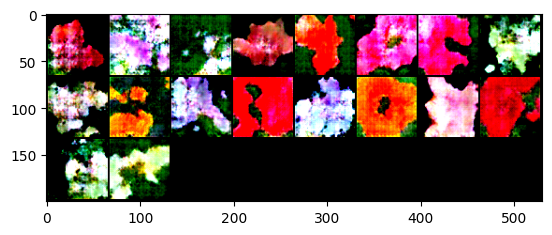

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 32, lossD:0.2532191460825575, lossG:10.060169020902764,lossG_fake:5.3448647133355, lossG_real:4.715304301635733 ,equality:0.6295604116997673


evaluate:110.88992309570312,kid_mean:0.08596906065940857, kid_std:0.041545405983924866,kid_:(tensor(0.0860), tensor(0.0415))


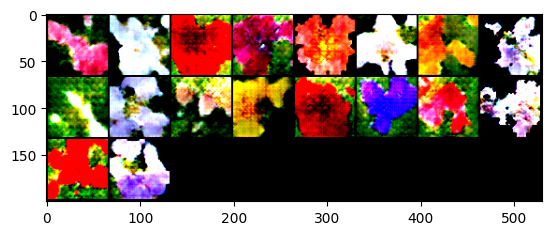

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 33, lossD:0.27762216873900986, lossG:10.112693388485214,lossG_fake:5.320593141815038, lossG_real:4.79210027560447 ,equality:0.5284928662105672


evaluate:102.18328094482422,kid_mean:0.08580712974071503, kid_std:0.043166495859622955,kid_:(tensor(0.0858), tensor(0.0432))


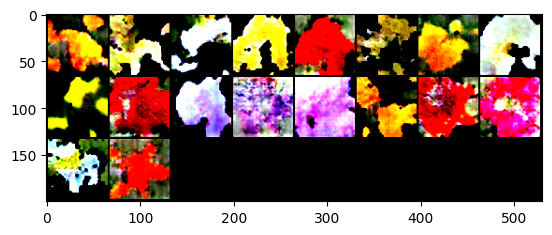

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 34, lossD:0.21124570928875683, lossG:9.904401626401734,lossG_fake:5.292552627406074, lossG_real:4.61184905802162 ,equality:0.6807035693844545


evaluate:100.26921081542969,kid_mean:0.08027737587690353, kid_std:0.04982057586312294,kid_:(tensor(0.0803), tensor(0.0498))


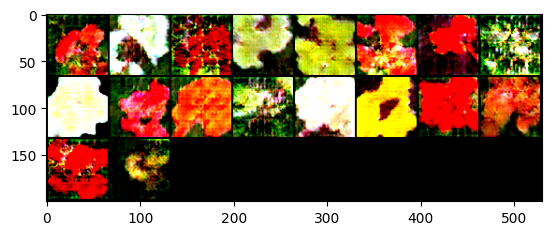

100%|██████████| 103/103 [00:09<00:00, 10.35it/s]


epoch: 35, lossD:0.29405541851827244, lossG:9.87015323268557,lossG_fake:5.199123727465139, lossG_real:4.6710294890172275 ,equality:0.5280942384479115


evaluate:97.64324188232422,kid_mean:0.07390248030424118, kid_std:0.04202450066804886,kid_:(tensor(0.0739), tensor(0.0420))


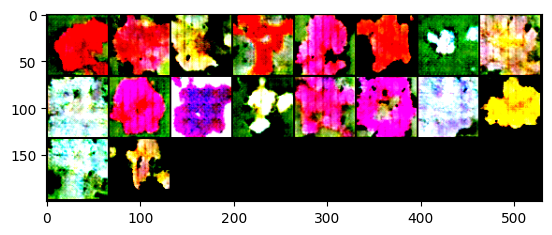

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 36, lossD:0.2731198654916969, lossG:10.254206620373772,lossG_fake:5.399599998900034, lossG_real:4.854606638255628 ,equality:0.5449933606444057


evaluate:92.60423278808594,kid_mean:0.08435987681150436, kid_std:0.046752698719501495,kid_:(tensor(0.0844), tensor(0.0468))


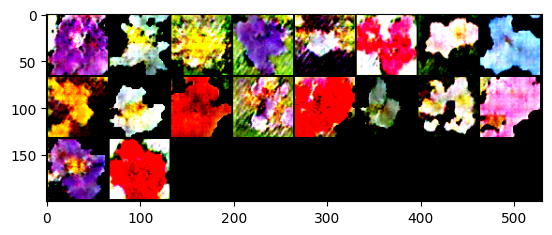

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 37, lossD:0.26080557250065134, lossG:10.315927153652154,lossG_fake:5.51836730670003, lossG_real:4.79755985158161 ,equality:0.72080745511842


evaluate:92.28270721435547,kid_mean:0.07904799282550812, kid_std:0.04297156631946564,kid_:(tensor(0.0790), tensor(0.0430))


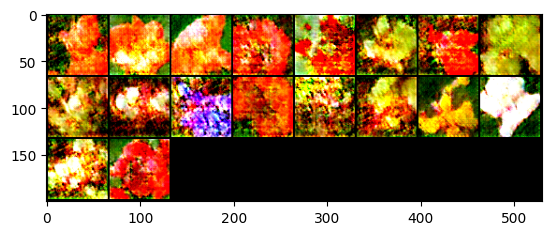

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 38, lossD:0.3448395340260371, lossG:10.189823599695002,lossG_fake:5.386626892876857, lossG_real:4.803196711447632 ,equality:0.5834301814292244


evaluate:88.4363021850586,kid_mean:0.06843394041061401, kid_std:0.040434788912534714,kid_:(tensor(0.0684), tensor(0.0404))


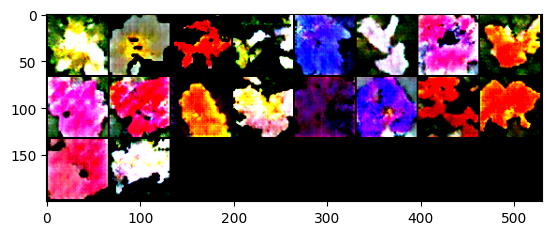

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 39, lossD:0.1729712890262164, lossG:9.719029088622158,lossG_fake:5.130658355731408, lossG_real:4.588370688910623 ,equality:0.5422876668207852


evaluate:89.28005981445312,kid_mean:0.07480437308549881, kid_std:0.044505711644887924,kid_:(tensor(0.0748), tensor(0.0445))


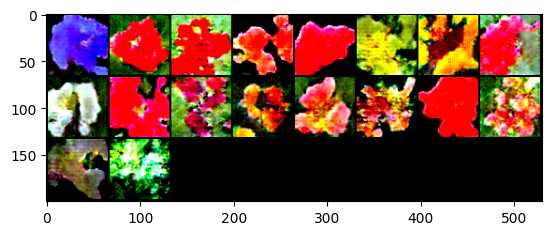

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 40, lossD:0.2564948358148047, lossG:10.465890671443013,lossG_fake:5.622769006247659, lossG_real:4.843121666352726 ,equality:0.7796473398949333


evaluate:86.07647705078125,kid_mean:0.07543537020683289, kid_std:0.03788748383522034,kid_:(tensor(0.0754), tensor(0.0379))


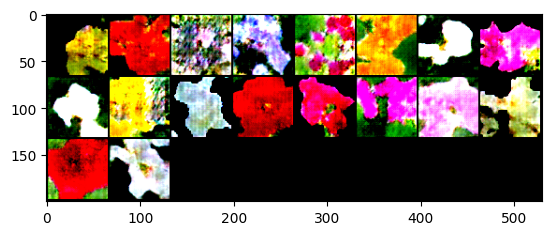

100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


epoch: 41, lossD:0.23918587549869874, lossG:10.286907696029514,lossG_fake:5.31824346942809, lossG_real:4.968664243383315 ,equality:0.3495792260447752


evaluate:86.9818344116211,kid_mean:0.07022681832313538, kid_std:0.040834031999111176,kid_:(tensor(0.0702), tensor(0.0408))


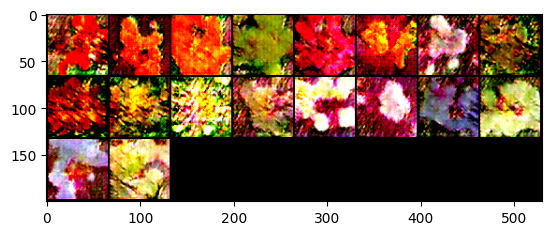

100%|██████████| 103/103 [00:09<00:00, 10.37it/s]


epoch: 42, lossD:0.2185083592256296, lossG:10.429014455924914,lossG_fake:5.574580069884513, lossG_real:4.854434397614118 ,equality:0.7201456722703954


evaluate:84.10406494140625,kid_mean:0.06883075088262558, kid_std:0.04144102707505226,kid_:(tensor(0.0688), tensor(0.0414))


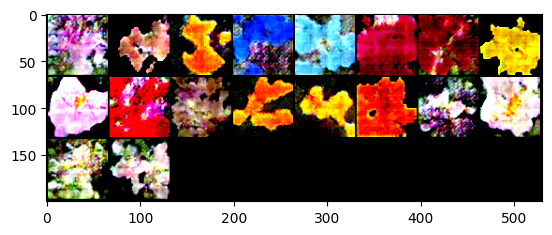

100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


epoch: 43, lossD:0.24771724104230264, lossG:10.66637116034054,lossG_fake:5.668525161095036, lossG_real:4.997846030494542 ,equality:0.6706791306004938


evaluate:84.8329849243164,kid_mean:0.07225105166435242, kid_std:0.04297884181141853,kid_:(tensor(0.0723), tensor(0.0430))


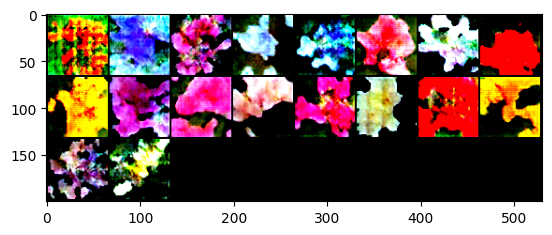

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 44, lossD:0.19528853193431803, lossG:10.615656074968356,lossG_fake:5.694455771770292, lossG_real:4.921200289309604 ,equality:0.7732554824606881


evaluate:84.32518005371094,kid_mean:0.06983401626348495, kid_std:0.04106650874018669,kid_:(tensor(0.0698), tensor(0.0411))


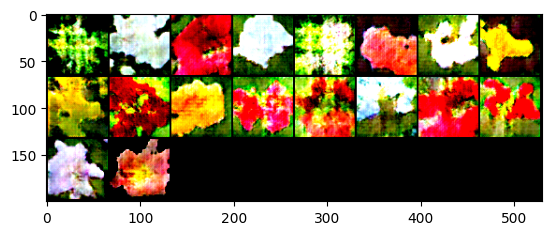

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 45, lossD:0.20465014746539223, lossG:10.786365842356265,lossG_fake:5.63093855492409, lossG_real:5.155427297920856 ,equality:0.4755112570032338


evaluate:84.80229949951172,kid_mean:0.0691005140542984, kid_std:0.03883526846766472,kid_:(tensor(0.0691), tensor(0.0388))


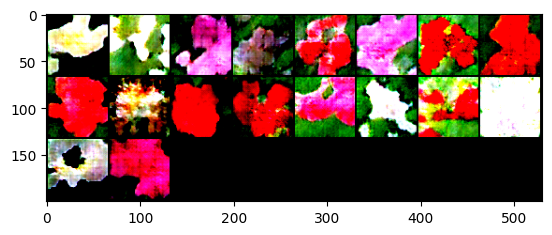

100%|██████████| 103/103 [00:10<00:00, 10.07it/s]


epoch: 46, lossD:0.3012193613550038, lossG:10.639497155124701,lossG_fake:5.630296621507811, lossG_real:5.009200555028268 ,equality:0.6210960664795433


evaluate:85.88920593261719,kid_mean:0.07260295003652573, kid_std:0.0464889295399189,kid_:(tensor(0.0726), tensor(0.0465))


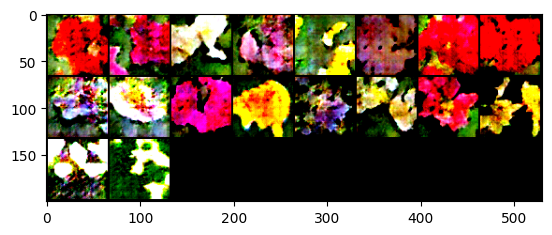

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 47, lossD:0.13575530887662784, lossG:10.39416402983434,lossG_fake:5.496547609856985, lossG_real:4.897616367895626 ,equality:0.5989312419613588


evaluate:86.68641662597656,kid_mean:0.08228730410337448, kid_std:0.046979084610939026,kid_:(tensor(0.0823), tensor(0.0470))


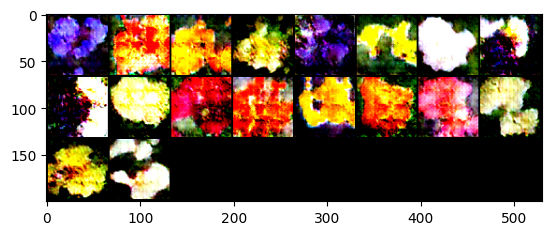

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 48, lossD:0.17858049564868284, lossG:10.848450956992732,lossG_fake:5.795515975905854, lossG_real:5.052934964883675 ,equality:0.7425810110221791


evaluate:87.07240295410156,kid_mean:0.0742424875497818, kid_std:0.03864932805299759,kid_:(tensor(0.0742), tensor(0.0386))


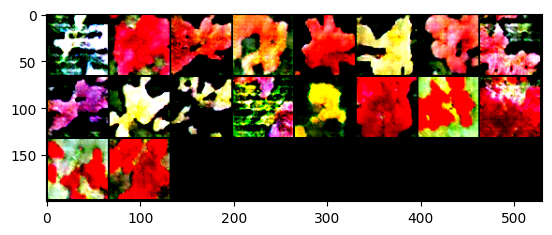

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 49, lossD:0.13378300445461735, lossG:10.771928027995582,lossG_fake:5.566936990589771, lossG_real:5.20499099111094 ,equality:0.36194599947883077


evaluate:87.42274475097656,kid_mean:0.07323402166366577, kid_std:0.05213751643896103,kid_:(tensor(0.0732), tensor(0.0521))


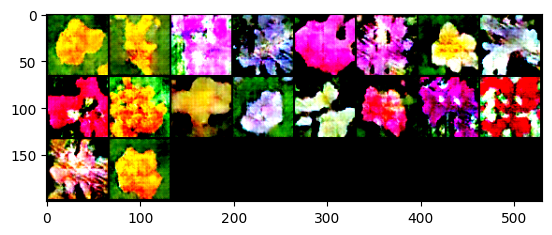

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

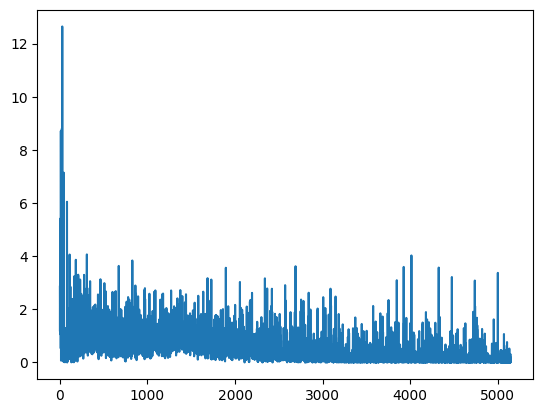

In [45]:
plt.plot(raw_lossesD)

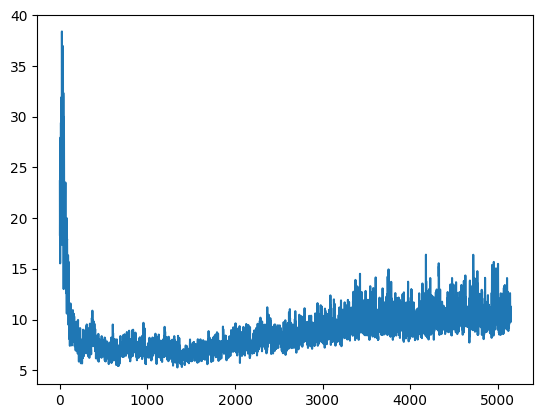

In [46]:
plt.plot(raw_lossesG)

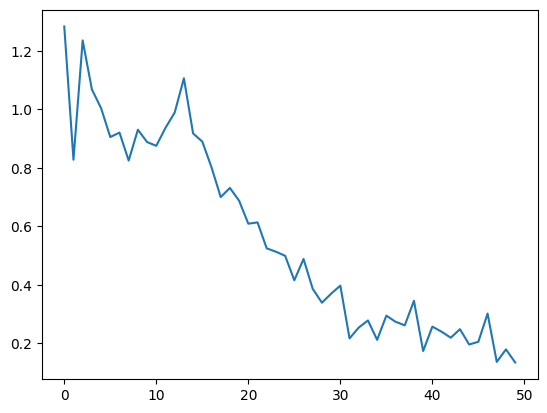

In [47]:
plt.plot(lossesD)

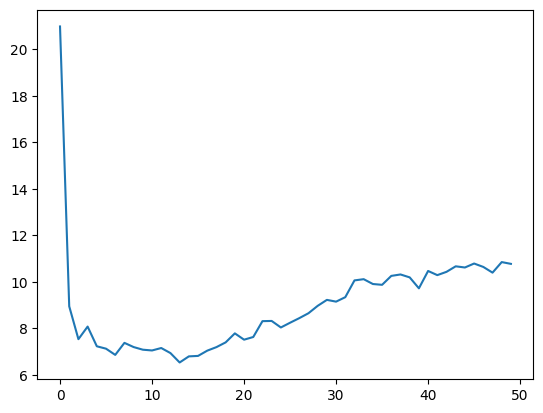

In [48]:
plt.plot(lossesG)

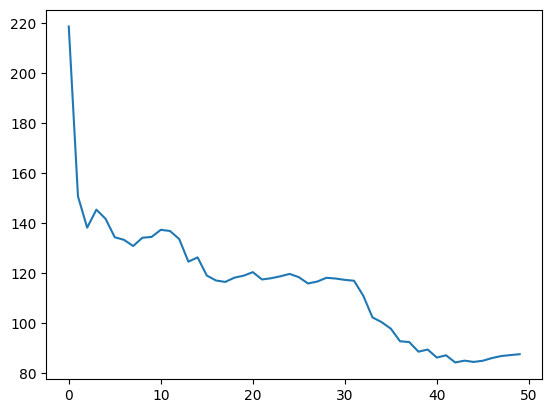

In [49]:
plt.plot(fid_)

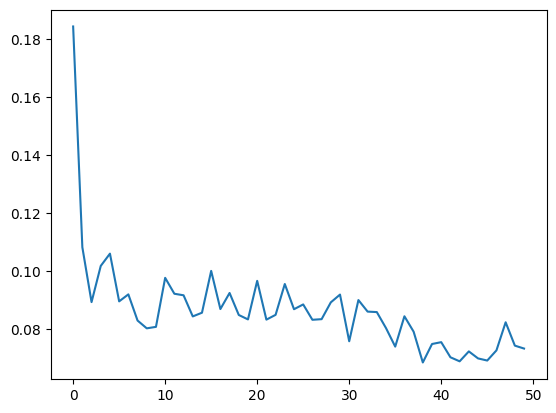

In [50]:
plt.plot(kid_mean_)

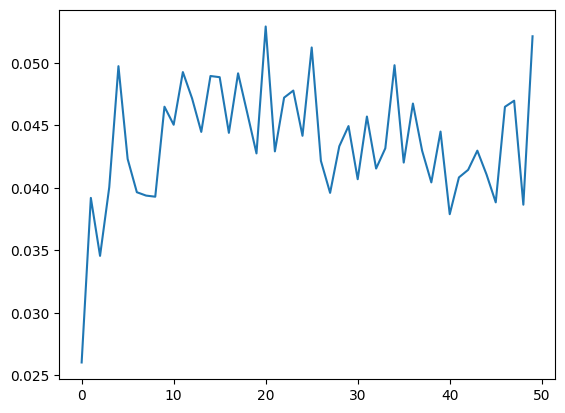

In [51]:
plt.plot(kid_std_)

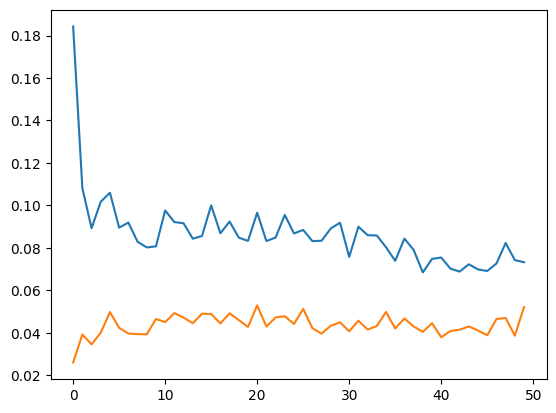

In [52]:
plt.plot(kid_score)

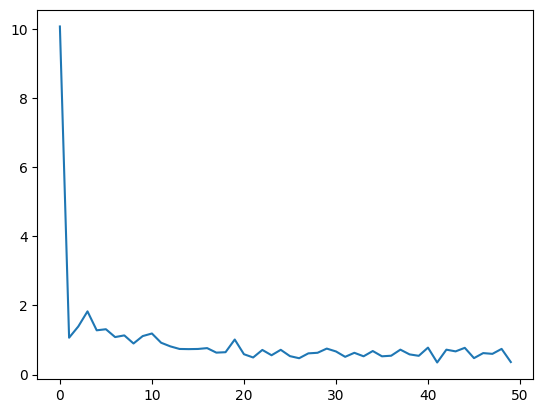

In [53]:
plt.plot(d_equality)

In [54]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00
fid  tensor(87.7678)
kid  (tensor(0.0731), tensor(0.0374))
PSNR tensor(71.4669)
SSIM値: 0.9796053362381829
